In [15]:
import os # provides methods for interacting with the operating system.

import numpy as np # Numerical Python, universal standard for working with numerical data.

import cv2 as cv # OpenCv.

import matplotlib.pyplot as plt # Most of Matplotlib utilities under the plt alias.
import matplotlib.image as mpimg # Basic image loading, rescaling and display.
%matplotlib inline

from PIL import Image # Image module of Python Imaging Library.

from IPython.display import display # Public API for display tools in IPython.

import torch # PyTorch: Tensor computation with strong GPU acceleration.
import torch.nn as nn # Pytorch module for neural network creation and training.
import torch.nn.functional as F # Convolution, pooling, activation and attention functions.
from torch.utils.data import DataLoader #  Python iterable over a dataset.
from torchvision import datasets, transforms, models # popular datasets, model architectures, and common image transformations for computer vision.
from torch.optim.lr_scheduler import StepLR # Decays the learning rate of each parameter group by gamma every step_size epochs.
## from torchsummary import summary: apparently torchsummary is dead, models.vgg16() from torchvision should do a similar job of outputing the model summary. (Need to test this)

from tqdm import tqdm # Show a smart progress meter.

### Data:

• *Steps*

-  Create an image classifier over a dataset of x-ray images of lungs with pneumonia and normal lungs.
-  Download dataset and place in local directory, accessible by the Python compiler. We will use open source data, found at: *https://www.kaggle.com/datasets/tolgadincer/labeled-chest-xray-images*
-  The dataset is divided into test and train folders, each further divided into NORMAL and PNEUMONIA categories.

   - *The number of train samples in the NORMAL category is 1349.*
   - *The number of train samples in the PNEUMONIA category is 234*
   - *The number of test samples in the PNEUMONIA category is 390*

*( cv.imread() from OpenCv and plt.show() from matplotlib )*

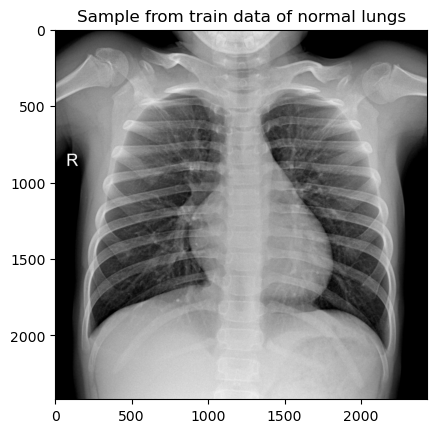

In [16]:
img_1 = cv.imread(r'img/chest_xray/train/NORMAL/NORMAL-28501-0001.jpeg')
plt.imshow(img_1)
plt.title('Sample from train data of normal lungs')
plt.show()

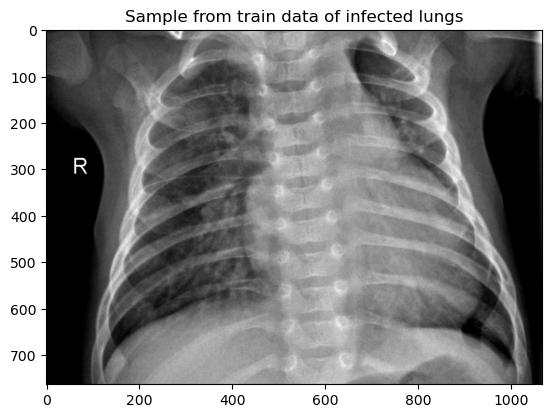

In [17]:
img_2 = cv.imread(r'img/chest_xray/train/PNEUMONIA/BACTERIA-7422-0001.jpeg')
plt.imshow(img_2)
plt.title('Sample from train data of infected lungs')
plt.show()

#### Imports:

 GPU is better for a faster process but CPU should also work. We need to install PyTorch, with CUDA support, in case we are using local CUDA cores. We need to be carefull about all the objects placed in CUDA for processing and all the objects placed in the CPU for processing.

 *The intermingling of data across different processor types is not supported unless they are specifically cast*. 

 *The custom libraries required for these classification problems have been listed in the beginning of this notebook*


Finally we set a data path for the data directory:


In [18]:
data_path = 'img\chest_xray'

### Data Exploration:

 We will now explore and check the sanity of the data. We have to assign *train* and *test* folders that can be used in the model. We can use the folder name as the class name if the images are segregated by folders. (*There can be another variation where we can see all images in one folder and then specify which image path belongs to which class.*)

##### *Define a Python function `get_list_files` and use it to obtain lists of filenames in different directories:*

In [19]:
class_name = ['NORMAL', 'PNEUMONIA'] # Define a list.
def get_list_files(dirName):
    '''
    input - directory location
    output - list the files in the directory
    '''
    files_list = os.listdir(dirName)
    return files_list

- Define the function with `dirName` argument.Takes a directory path `(dirName)` as input and returns a list of files present in that directory using `os.listdir.`  
- `os.listdir(dirName)` Returns the list of all files and directories in the specified directory.

##### *Call the `get_list_files()` function to see the number of test samples*:
- `data_path` variable is defined above
- `class_name[0]` is the 0 index item in the class_name list i.e 'NORMAL'

In [20]:
files_list_normal_train = get_list_files(data_path + '/train/' + class_name[0])
print(f'Train samples in Normal category: {len(files_list_normal_train)}')

files_list_pneumonia_train = get_list_files(data_path + '/train/' + class_name[1])
print(f'Train samples in Pneumonia category: {len(files_list_pneumonia_train)}')

files_list_normal_test = get_list_files(data_path + '/test/' + class_name[0])
print(f'Test samples in Normal category: {len(files_list_normal_test)}')

files_list_pneumonia_test = get_list_files(data_path + '/test/' + class_name[1])
print(f'Test samples in Pneumonia category: {len(files_list_pneumonia_test)}')


Train samples in Normal category: 1349
Train samples in Pneumonia category: 3883
Test samples in Normal category: 234
Test samples in Pneumonia category: 390


##### *View samples*

*Now that we have counted the images and located their path, let's see how to view the sample images from NORMAL and PNEUMONIA folders:*

- define `rand_img_no` variable with `np.random.randint` that returns random integers. `np.random.randint(0,len(files_list_normal_train))` generates a random integer using Numpy's randint function. The first argument (0) is the inclusive lower bound, and the second argument `(len(files_list_normal_train))` is the exclusive upper bound. It means the random integer can be any value from 0 to the length of `files_list_normal_train` minus 1. $[x,y)$
- `img` variable, contains the full file path to a randomly selected image from the 'NORMAL' class in the training set.

Image dimensions: (1245, 1462)


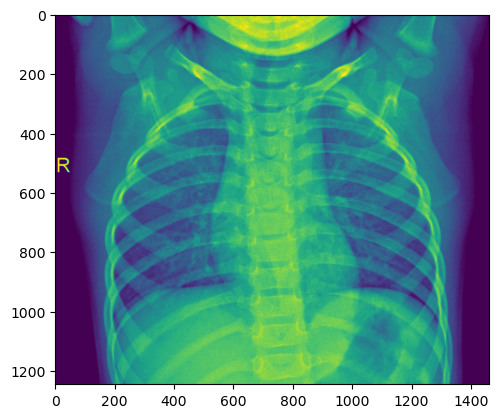

In [22]:
rand_img_no = np.random.randint(0,len(files_list_normal_train))
img = data_path + '/train/NORMAL/' + files_list_normal_train[rand_img_no]
print(f'Image dimensions: {plt.imread(img).shape}')
img = mpimg.imread(img)
imgplot = plt.imshow(img)
plt.show()

- `imread().shape` retrieves the dimensions (shape) of the image.
- `mpimg.imread(img)`  reads the image with Matplotlib.
- `plt.imshow(img)`  Displays the image with imshow.
- `plt.show()` shows the image; without this, the image would be created but not displayed.

### Data Loader
 
 Now that we have explored the data, let's setup the data loaders for training purposes. We will crop and resize the images to a uniform size of $224x224$. This is not set in stone, a different size can be used.  
 We will also convert the images to tensors for the PyTorch framework. We will try to normalize the images with mean and standard deviation values. *Subtracting the mean centers the input to 0, and dividing by the standard deviation makes any scaled feature value the number of standard deviations away from the mean.* $z\equiv\frac{ x - μ}{σ}$
 If we are considering three channels per image, then we need to provide three values for one channel. We need one combination of mean and standard deviation.

In [10]:
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])])
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])])

- `transforms.Resize(224)`: Resizes the image to have a minimum size of 224. If the image is smaller than this size, it will be scaled up. If it's larger, it will be scaled down.

- `transforms.CenterCrop(224)`: Performs a center crop on the image, extracting a square region of size 224x224 pixels. This is often used to create square input images.

- `transforms.ToTensor()`: Converts the image to a PyTorch tensor. PyTorch tensors are the primary data structure used in PyTorch for storing and manipulating multi-dimensional arrays.

- `transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])`: Normalizes the tensor. This involves subtracting the mean and dividing by the standard deviation. The values `[0.485, 0.456, 0.406]` and `[0.229, 0.224, 0.225]` are the mean and standard deviation values for the three color channels (RGB). These *specific values* are often used for normalization when working with models pretrained on large datasets like ImageNet.
*( see: https://stackoverflow.com/questions/65676151how-does-torchvision-transforms-normalize-operate)*.  
*Normalizing data includes them in the same range as our activation functions, usually between 0 and 1. This allows for less frequent non-zero gradients during training, and therefore the neurons in our network will learn faster.
By normalizing each channel so that they have the same distribution, we ensure that the channel information can be mixed and updated during the gradient descent (back propagation) using the same learning rate.*

- The `transforms.Compose` function is then used to combine these transformations into a single transform that can be applied to an image.

In [11]:
train_data = datasets.ImageFolder(os.path.join(data_path, 'train'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(data_path, 'test'), transform=test_transform)

- `train_data` and `test_data` are instances of the `Imagefolder` class representing the training and testing datasets, respectively. These will be used with PyTorch's `Dataloader` for iterating through batches during training or evaluation.
- `ImageFolder` class, automatically assigns labels to images based on the subdirectory they are in.
- The `os.path.join(data_path, 'train/test')` command is used to create a path by joining the data_path variable with the subdirectory `'train/test'`.
- The `transform` argument applies the specified transformations.

In [12]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False, pin_memory=True)